# Assignment 2

> Group Members: Julius Kappenberg, Alexandros Gilch, Paul Grass, Tim Mensinger, Philipp Schirmer

## Question II: Fiscal Policy

This notebook is structured as follows: First we clean the data and perform the log transformation of columns. We then answer question *i.* Aferwards we implement a local projection function which we use to answer question *ii.* (the implementation can be skipped). At last we summarize our findings and answer question *iii.* 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

## Data Cleaning

In [2]:
df = pd.read_stata("data/fiscal_data1930s.dta")
df = df.set_index("date")


def _log_transform(column, ignore=None):
    column = column.copy()
    ignore = ignore if isinstance(ignore, list) else [ignore]
    if column.name not in ignore:
        column = 100 * np.log(column)
    return column


df = df.transform(_log_transform, ignore="irate")

In [3]:
df.head()

,gdp_pc,ip,g_pc,g_mil_pc,rev_pc,wpi,irate,unemp
date,,,,,,,,
1927-04-01,428.262029,462.281835,175.692230,117.088593,184.588394,490.379220,5.0,724.943359
1927-05-01,428.494448,464.662937,188.093063,126.212456,213.380951,492.071059,5.0,718.639221
1927-06-01,428.956984,463.184178,164.157944,75.750061,193.909149,492.652878,6.0,714.218323
1927-07-01,429.649906,468.730094,167.101929,89.459831,180.464691,492.435093,6.0,709.271973
1927-08-01,430.138579,468.647081,159.718750,59.362907,181.848373,492.652878,6.0,704.679688


## Results
 
#### i.
From the question description we recall
 
 > The identifying assumption is that public expenditures are predetermined within a given period (i.e., they do not react to shocks to other variables in the same time period).
 
The below histogram illustrates the time difference between consecutive periods in days. We see that the data contains monthly observations. One may argue that during the period of a month, shocks can occur to other variables to which the political process responds with a change in spending in the same period. However, since the political process is known to be slow, the assumption that such a response takes _at least a month_ does seem reasonable. Even in (economic) crises, bureaucracy may not allow for responses to be significantly faster than a month.

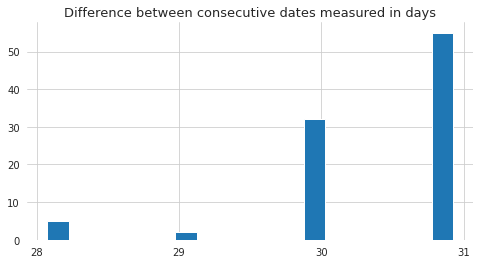

In [4]:
diff = np.diff(df.index).astype("timedelta64[D]")
diff = pd.Series(diff).dt.days

fig, ax = plt.subplots(1)
fig.set_size_inches(8, 4)
diff.hist(ax=ax, rwidth=0.5)
ax.set_frame_on(False)
ax.set_title("Difference between consecutive dates measured in days", size=13)
_ = ax.set_xticks(diff.unique())

### ii.

#### Implementation of Local Projection Method

In [5]:
def _create_formula_with_lags(var_name, n_lags):
    """Creates formula str of var_name with n_lags."""
    covariates = [f"{var_name}.shift({i})" for i in range(1, n_lags + 1)]
    formula = " + ".join(covariates)
    return formula


def _create_formula_to_extract_shocks(endog, exog, n_lags):
    """Creates callable formula str with lagged exog regressors."""
    exog_formulas = [_create_formula_with_lags(name, n_lags) for name in exog]
    formula = f"{endog} ~ 1 + " + " + ".join(exog_formulas)
    return formula


def local_projection(df, n_response_periods, n_lags):
    """Estimate impulse response using local projections.
    
    This function is not written in a general manner and this is
    on purpose. Sets of exogeneous and endogeneous variables are
    defined inside to avoid overly abstract code.
    
    Args:
        df (pandas.DataFrame): The data.
        n_response_periods (int): Number of response periods.
        n_lags (int): Number of lags to use in shock creation.
        
    Returns:
        Dict[pandas.DataFrame]: Dictionary containing
            impulse_response: The estimated impulse responses.
            df: The updated initial data frame.
    
    """
    # extract shock from data
    formula = _create_formula_to_extract_shocks(
        endog="g_pc", exog=("g_pc", "gdp_pc", "rev_pc"), n_lags=6
    )
    model = sm.ols(formula, df).fit()
    df = df.assign(**{"shock": model.resid})

    # estimate impulse responses
    impulse_response = pd.DataFrame(columns=["h", "endog", "value"])
    impulse_response = impulse_response.set_index(["h", "endog"])

    for h in range(n_response_periods):
        for endog in df.columns.drop("shock"):
            formula = f"{endog}.shift({-h-1}) ~ 1 + shock"
            model = sm.ols(formula, df).fit()
            theta = model.params["shock"]
            impulse_response.loc[(h + 1, endog), "value"] = theta

    # result processing
    result = {
        "impulse_response": impulse_response.reset_index().convert_dtypes(),
        "df": df,
    }
    return result

#### Application of Local Projection Method

In [6]:
result = local_projection(df, n_response_periods=24, n_lags=6)

#### Plotting

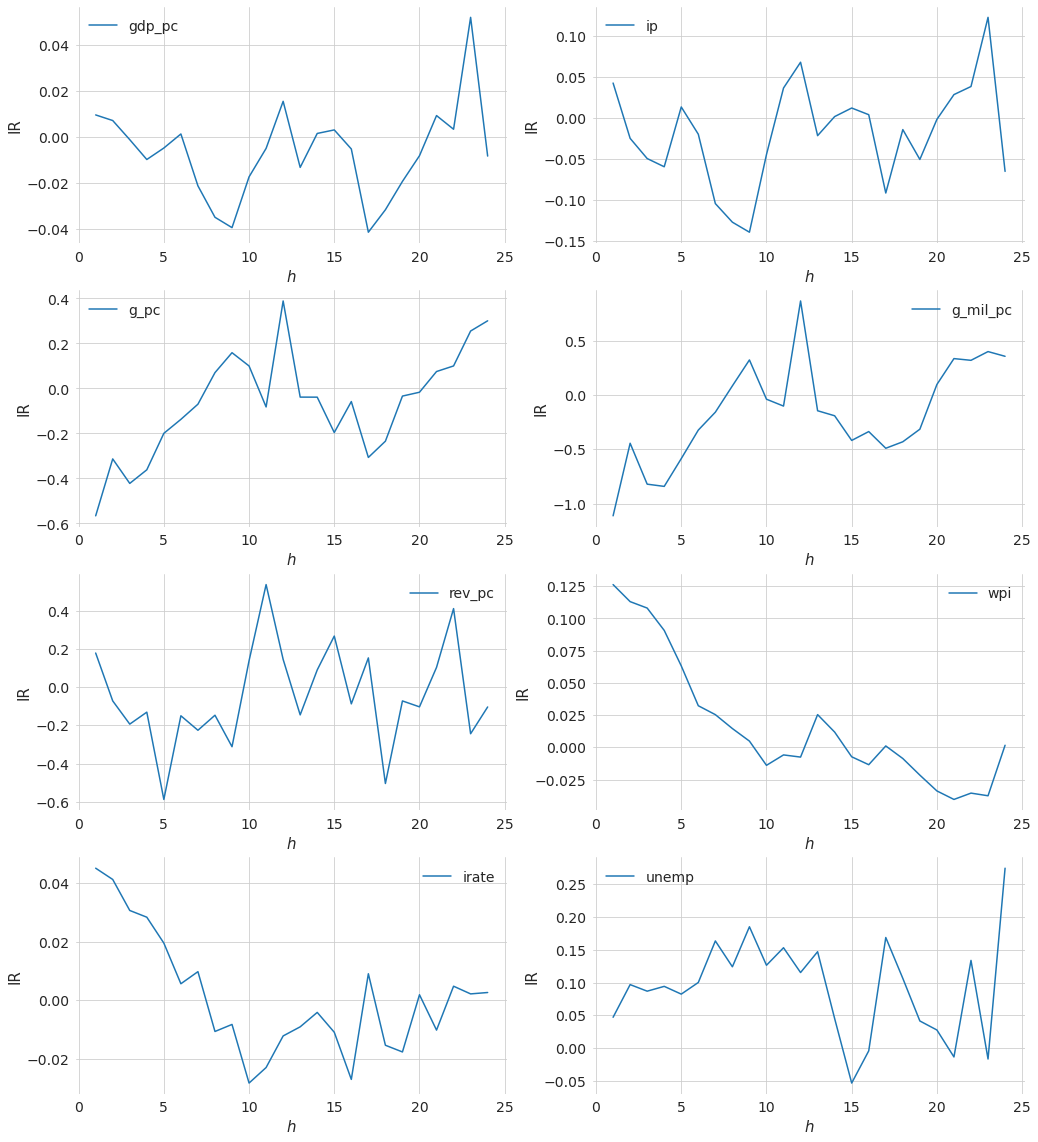

In [7]:
fig, axes = plt.subplots(4, 2)
fig.set_size_inches(17, 20)

for ax, col in zip(axes.flatten(), df.columns):
    
    _data = result["impulse_response"].query("endog == @col")
    _data = _data.assign(value= -1 * _data.value)  # decrease not increase

    sns.lineplot(
        x="h",
        y="value",
        hue="endog",
        data=_data,
        ax=ax,
    )
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set(ylabel="IR", xlabel=r"$h$")
    ax.set_frame_on(False)
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    _ = ax.legend(frameon=False, fontsize=14,)

### iii.